In [2]:
#imports

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tqdm import tqdm
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.backend import squeeze
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Reshape
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, concatenate,Permute, Conv2DTranspose
from tensorflow.keras.activations import relu
from sklearn import utils
import wandb
from wandb.keras import WandbCallback
import os
from numpy import array, rec

#Use this if training on a multi-GPU machine
#os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"# Assign which GPU to run on

2.4.1
range(1, 71999)
71998


100%|██████████| 71999/71999 [00:08<00:00, 8791.24it/s]


(68399, 80, 240, 1)
(3600, 80, 240, 1)
(68399, 20, 60, 15, 1)
(3600, 20, 60, 15, 1)
84.0
####
######


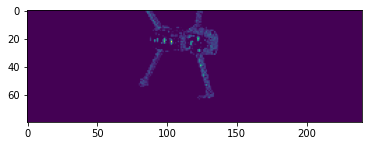

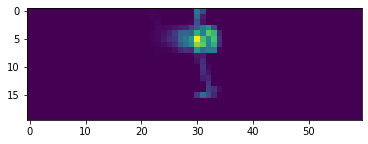

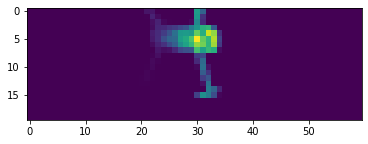

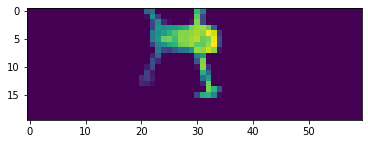

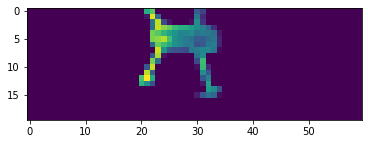

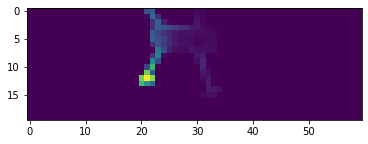

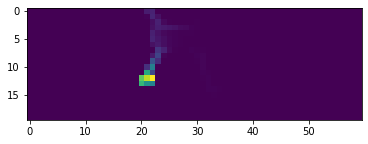

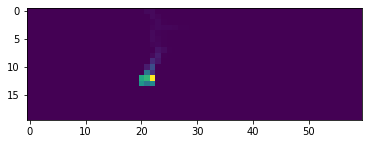

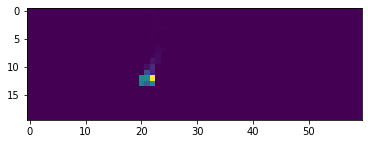

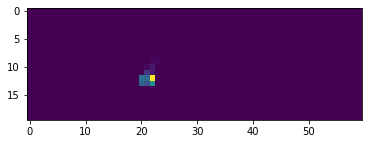

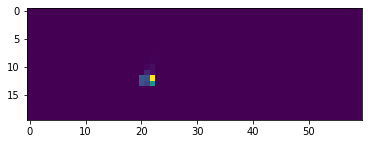

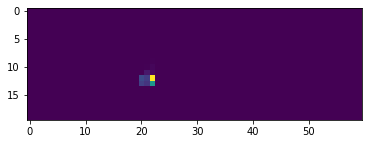

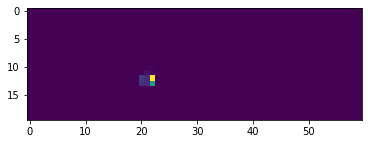

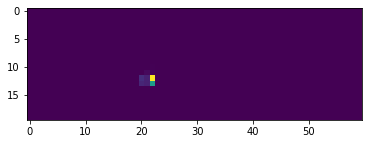

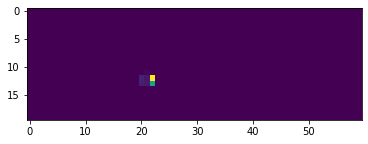

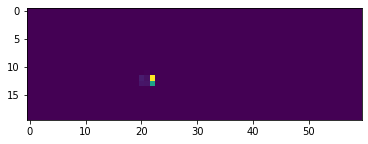

######


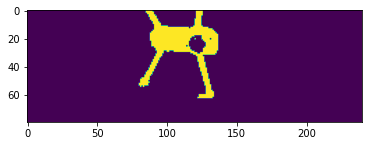

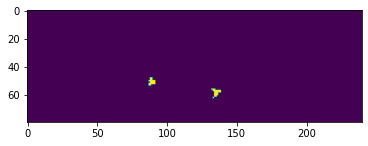

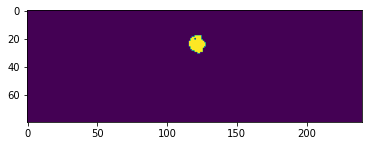

In [4]:
#Training and testing data for a single drone
train_inten_DATADIR = "/Put_File_Path_Here/Training/Intensity/"
train_label_DATADIR = "/Put_File_Path_Here/Training/Segmentation/"
train_depth_DATADIR = "/Put_File_Path_Here/Training/Depth/"

test_inten_DATADIR = "/Put_File_Path_Here/Testing/Intensity/"
test_label_DATADIR = "/Put_File_Path_Here/Testing/Segmentation/"
test_depth_DATADIR = "/Put_File_Path_Here/Testing/Depth/"


inten_training_data = np.zeros((68399,80,240,1))
inten_testing_data = np.zeros((3600,80,240,1))

start_number_inten_imgs = 1
end_number_inten_imgs = 71999

test_imgs = range(1,3600+1,1)

def create_iten_data():
    count_1 = 0
    count_2 = 0
    for i in tqdm(range(start_number_inten_imgs,end_number_inten_imgs+1,1)):
        #print(i)
        if i in test_imgs:

            path_0 = test_inten_DATADIR+str(i)+".bmp"

            img_array = cv2.imread(path_0 ,cv2.IMREAD_GRAYSCALE)
            new_array = img_array[40:120,0:240]
            inten_testing_data[count_1,:,:,0] = new_array
            count_1 = count_1+1    
        else:

            path_0 = train_inten_DATADIR+str(i)+".bmp"

            img_array = cv2.imread(path_0 ,cv2.IMREAD_GRAYSCALE)
            new_array = img_array[40:120,0:240]
            inten_training_data[count_2,:,:,0] = new_array
            count_2 = count_2+1


create_iten_data()

depth_training_data = np.zeros((68399,20,60,15,1))
depth_testing_data = np.zeros((3600,20,60,15,1))

depth_img_original_r = 32
depth_img_original_c = 64 

def create_depth_data():
    count_1 = 0
    count_2 = 0
    for i in tqdm(range(start_number_inten_imgs,end_number_inten_imgs+1,1)):
        
        if i in test_imgs:

            path_0 = test_depth_DATADIR+str(i)+".csv"

            histo_array = np.loadtxt(path_0, delimiter=',', usecols=range(15))# convert to array
            histo_array = np.reshape(histo_array,(depth_img_original_r,depth_img_original_c,15), order="F") #order "F" means fortran like, makes it work like matlab reshape
            new_array = histo_array[10:30,0:60,:]#adjust image size to match SPAD data

            depth_testing_data[count_1,:,:,:,0] = new_array
            count_1 = count_1+1    
        else:

            path_0 = train_depth_DATADIR+str(i)+".csv"

            #print(path_0)

            histo_array = np.loadtxt(path_0, delimiter=',', usecols=range(15))# convert to array
            histo_array = np.reshape(histo_array,(depth_img_original_r,depth_img_original_c,15), order="F") #order "F" means fortran like, makes it work like matlab reshape
            new_array = histo_array[10:30,0:60,:]#adjust image size to match SPAD data

            depth_training_data[count_2,:,:,:,0] = new_array
            count_2 = count_2+1


print(inten_training_data.shape)
print(inten_testing_data.shape)

print(depth_training_data.shape)
print(depth_testing_data.shape)

create_depth_data()#Only run once

np.save('depth_training_data.npy', depth_training_data) # saves the histogram array which is slow to generate, only run once
np.save('depth_testing_data.npy', depth_testing_data)

depth_training_data = np.load('depth_training_data.npy')
depth_testing_data = np.load('depth_testing_data.npy')

train_labels = np.zeros((68399,80,240,3))#layer 0 = body, 2 = engines, 3 = camera

test_labels = np.zeros((3600,80,240,3))#layer 0 = body, 2 = engines, 3 = camera


def create_labels():
    count_1 = 0
    count_2 = 0
    for i in tqdm(range(start_number_inten_imgs,end_number_inten_imgs+1,1)):
        
        if i in test_imgs:

            path_0 = test_label_DATADIR+str(i)+".csv"

            label_array = np.loadtxt(path_0, delimiter=',', usecols=range(240))# convert to array

            test_labels[count_1,label_array[40:120,0:240]==0,0] = 1 # body
            test_labels[count_1,label_array[40:120,0:240]==1,1] = 1 # engines
            test_labels[count_1,label_array[40:120,0:240]==2,2] = 1 # camera
            
            count_1 = count_1+1    
        else:

            path_0 = train_label_DATADIR+str(i)+".csv"

            label_array = np.loadtxt(path_0, delimiter=',', usecols=range(240))# convert to array

            train_labels[count_2,label_array[40:120,0:240]==0,0] = 1 # body
            train_labels[count_2,label_array[40:120,0:240]==1,1] = 1 # engines
            train_labels[count_2,label_array[40:120,0:240]==2,2] = 1 # camera
            

            count_2 = count_2+1


create_labels()#only run once


np.save('segmentation_Training_Labels_With_Noise_Inten_And_Histo_Mavic_2_Seg_With_Movement_Cont_Full_Ang.npy', train_labels) # saves the labels array which is slow to generate, only run once
np.save('segmentation_Testing_Labels_With_Noise_Inten_And_Histo_Mavic_2_Seg_With_Movement_Cont_Full_Ang.npy', test_labels)

train_labels = np.load('segmentation_Training_Labels_With_Noise_Inten_And_Histo_Mavic_2_Seg_With_Movement_Cont_Full_Ang.npy')
test_labels = np.load('segmentation_Testing_Labels_With_Noise_Inten_And_Histo_Mavic_2_Seg_With_Movement_Cont_Full_Ang.npy')

#view the trianing data
print("######")

plt.imshow(inten_training_data[400,:,:,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,0,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,1,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,2,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,3,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,4,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,5,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,6,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,7,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,8,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,9,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,10,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,11,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,12,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,13,0]*20.0)
plt.show()
plt.imshow(depth_training_data[400,:,:,14,0]*20.0)
plt.show()

print("######")

plt.imshow(train_labels[400,:,:,0])
plt.show()
plt.imshow(train_labels[400,:,:,1])
plt.show()
plt.imshow(train_labels[400,:,:,2])
plt.show()

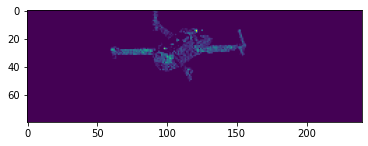

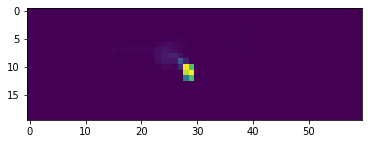

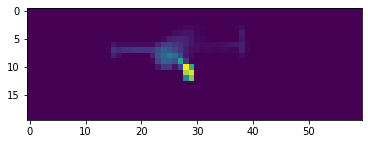

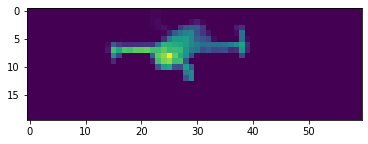

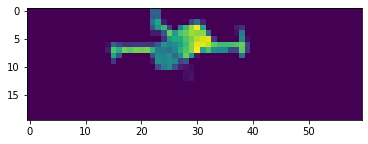

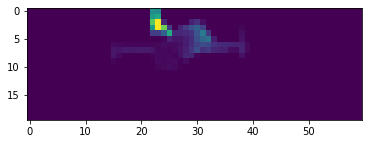

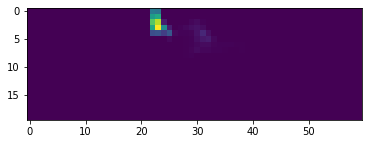

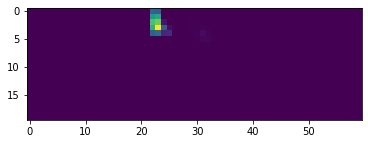

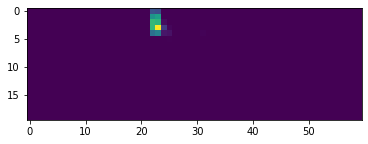

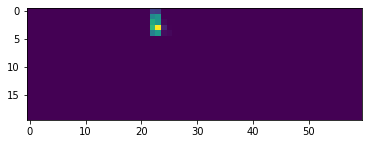

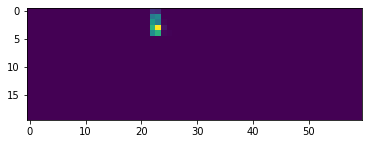

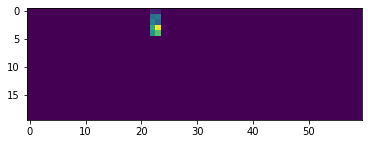

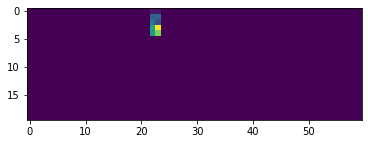

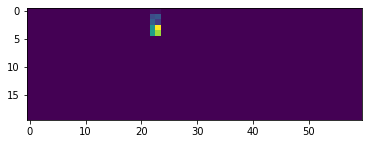

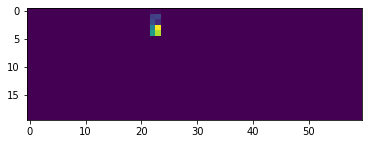

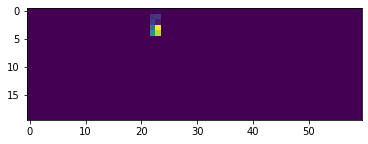

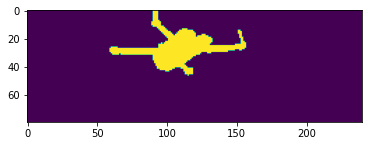

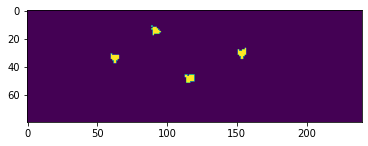

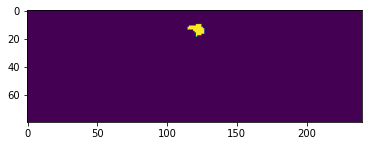

(68399, 80, 240, 1)
(68399, 20, 60, 15, 1)
(68399, 80, 240, 3)


In [5]:
#shuffle the training data
randomize = np.arange(np.shape(train_labels)[0])

np.random.shuffle(randomize)

inten_training_data = inten_training_data[randomize]
depth_training_data = depth_training_data[randomize]
train_labels = train_labels[randomize]

#view the training data
plt.imshow(inten_training_data[0,:,:,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,0,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,1,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,2,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,3,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,4,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,5,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,6,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,7,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,8,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,9,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,10,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,11,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,12,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,13,0]*20.0)
plt.show()
plt.imshow(depth_training_data[0,:,:,14,0]*20.0)
plt.show()

plt.imshow(train_labels[0,:,:,0])
plt.show()
plt.imshow(train_labels[0,:,:,1])
plt.show()
plt.imshow(train_labels[0,:,:,2])
plt.show()


print(np.shape(inten_training_data))
print(np.shape(depth_training_data))
print(np.shape(train_labels))


In [6]:
#Segmentation prediction network

#wandb.init(project="W_N_I_A_H_O_B_O_W_M_C_A_C_L_M_A",config={"hyper": "parameter"})# initialize weights and biases if in use

depth_inputs = Input(shape = (20,60,15,1))#20x60x15x1
depth_C1 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(depth_inputs)
depth_C2 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(depth_C1)

print(depth_C1.shape)
depth_MP_1 = MaxPooling3D(pool_size=(1, 1,3),padding='same')(depth_C2)
print(depth_MP_1.shape)
depth_C4 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(depth_MP_1)
depth_C5 = Conv3D(32, (3, 3,3), activation = 'relu',padding='same',data_format="channels_last")(depth_C4)

print(depth_C2.shape)
depth_MP_2 = MaxPooling3D(pool_size=(1, 1,5),padding='same')(depth_C5)
print(depth_MP_2.shape)
depth_MP_2 = squeeze(depth_MP_2,3)


inten_inputs = Input(shape = (80,240,1))#80x240x1
inten_C1 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(inten_inputs)
inten_C2 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(inten_C1)

print(inten_C1.shape)
inten_MP_1 = MaxPooling2D(pool_size=(4, 4),padding='same')(inten_C2)
print(inten_MP_1.shape)

joined = concatenate([inten_MP_1,depth_MP_2],axis=3)
print(joined.shape)


joined_C1 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(joined)
joined_C2 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(joined_C1)

print(joined_C2.shape)
joined_MP_1 = MaxPooling2D(pool_size=(4, 4),padding='same')(joined_C2)
print(joined_MP_1.shape)
joined_C4 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(joined_MP_1)
joined_C5 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(joined_C4)

print("joined_C5")
print(joined_C5.shape)
joined_MP_2 = MaxPooling2D(pool_size=(5, 5),padding='same')(joined_C5)


print("throat")
print(joined_MP_2.shape)

up_Joined_1 = Conv2DTranspose(32,(3,3), activation = 'relu',padding='same',data_format="channels_last",strides=(5,5))(joined_MP_2)

print("pre-cat")
print(up_Joined_1.shape)

up_Joined_1 = concatenate([up_Joined_1,joined_C5],axis=3)
print("post-cat")
print(up_Joined_1.shape)
up_Joined_C1 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(up_Joined_1)
up_Joined_C2 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(up_Joined_C1)
print("up_Joined_C2")
print(up_Joined_C2.shape)

up_Joined_2 = Conv2DTranspose(32,(3,3), activation = 'relu',padding='same',data_format="channels_last",strides=(4,4))(up_Joined_C2)

up_Joined_2 = concatenate([up_Joined_2,joined_C2],axis=3)

up_Joined_C3 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(up_Joined_2)
up_Joined_C4 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(up_Joined_C3)

up_Joined_3 = Conv2DTranspose(32,(3,3), activation = 'relu',padding='same',data_format="channels_last",strides=(4,4))(up_Joined_C4)

up_Joined_3 = concatenate([up_Joined_3,inten_C2],axis=3)
up_Joined_C5 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(up_Joined_3)
up_Joined_C6 = Conv2D(32, (3, 3), activation = 'relu',padding='same',data_format="channels_last")(up_Joined_C5)

seg_img = Conv2D(3, (3,3), activation = 'sigmoid',padding='same',data_format="channels_last")(up_Joined_C6)# One filter for each component being identified

seg_model = Model(inputs = [inten_inputs,depth_inputs],outputs = seg_img)

print(seg_model.summary())


seg_model.compile(loss='binary_crossentropy',optimizer = "Adam",metrics=['accuracy'])
checkpoint_filepath = '/Your_File_Path_Here/Seg'# filepath for model checkpoints


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='loss', mode='min', save_best_only=True)

seg_model.fit([inten_training_data,depth_training_data], train_labels, batch_size=128, epochs=100,validation_data=([inten_testing_data,depth_testing_data], test_labels), callbacks=[model_checkpoint_callback])

K.clear_session()#Helps prevent GPU memory leakage

(None, 20, 60, 15, 32)
(None, 20, 60, 5, 32)
(None, 20, 60, 15, 32)
(None, 20, 60, 1, 32)
(None, 80, 240, 32)
(None, 20, 60, 32)
(None, 20, 60, 64)
(None, 20, 60, 32)
(None, 5, 15, 32)
joined_C5
(None, 5, 15, 32)
throat
(None, 1, 3, 32)
pre-cat
(None, 5, 15, 32)
post-cat
(None, 5, 15, 64)
up_Joined_C2
(None, 5, 15, 32)
out_size
(None, 80, 240, 3)
68399
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 60, 15,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 20, 60, 15, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (Non